Sta 663 - Statistical Computing and Computation - Midterm 1
-----------
Due Monday, March 20 by noon.

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Load data
d1 = pd.read_csv("data/d1.csv")
d2 = pd.read_csv("data/d2.csv")
d3 = pd.read_csv("data/d3.csv")

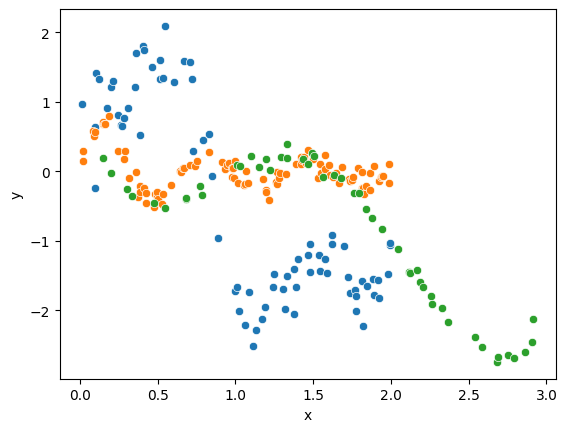

In [3]:
# Draw a scatterplot first to get a sense of the data
for i in [d1, d2, d3]:
    sns.scatterplot(x = "x", y = "y", data = i)

## Preparation
Below are the helper functions that calculate the covariance matrices used in the later tasks. 

The covariance matrix is constructed using the following formula, $$ \Sigma_{i,j}(x) = \text{cov}(x_i, x_j) = \sigma^2_n \, \mathcal{I}_{i = j} + \sigma^2_s \exp{\left(- \frac{(x_i-x_j)^2}{2l}\right)} $$
and 
$$ \Sigma_{i,j}(x_p, x) = \text{cov}({x_p}_i, x_j) = \sigma^2_s \exp{\left(- \frac{({x_p}_i-x_j)^2}{2l}\right)} $$
where $\sigma^2_n$, $\sigma^2_s$ and $l$ are the models parameters (what
we will be estimating via MLE from the data).

Note that in the cross covariance matrix case, the dimensions of $x_p$ (prediction locations) and $x$ (original data locations) generally differ. Therefore $\Sigma(x_p, x)$ is $n_p \times n$ and not a sqaure matrix. Its diagonal entries do not need the nugget variance parameter. 

Finally, using a for-loop and computing the covariance matrix by entry is intuitive and easily readable. But taking advantage of numpy vectorization can further save computation time in constructing the covariance matrix. The formulations and logics are essentially the same. 

In [4]:
# Helper functions

def compute_cov(x, sigma_n2, sigma_s2, l):
    
    n = len(x)
    cov_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            # diagnoal entry
            if i == j:
                cov_matrix[i, j] = sigma_n2 + sigma_s2 * np.exp(-(x[i]-x[j])**2/(2*l))
            # non-diagnoal entry
            else:
                cov_matrix[i, j] = sigma_s2 * np.exp(-(x[i]-x[j])**2/(2*l))
    
    return cov_matrix


def compute_cov2(x_p, x, sigma_n2, sigma_s2, l):
    
    n = len(x)
    n_p = len(x_p)
    cov_matrix = np.zeros((n_p, n))

    for i in range(n_p):
        for j in range(n):
            cov_matrix[i, j] = sigma_s2 * np.exp(-(x_p[i]-x[j])**2/(2*l))
    
    return cov_matrix

In [5]:
# Helper funtion of the same purpose, but taking advantage of np vectorization to save computation time

def compute_cov(x, sigma_n2, sigma_s2, l):
    
    n = len(x)
    x = np.array(x)

    cov_matrix = sigma_n2 * np.eye(n) + sigma_s2 * np.exp(-(x[:,np.newaxis]-x[np.newaxis,:])**2/(2*l))
    
    return cov_matrix

def compute_cov2(x_p, x, sigma_n2, sigma_s2, l):
    
    x_p = np.array(x_p); x = np.array(x)
    
    cov_matrix = sigma_s2 * np.exp(-(x_p[:,np.newaxis]-x[np.newaxis,:])**2 / (2*l))
    
    return cov_matrix

## Task 1 - Model fitting

In this task, I implemented a `fit` function which optimizes parameters values of Gaussian process regression models via maximum likelihood estimation. It returns the maximum likelihood estimations of three parameters, $\sigma^2_n, \sigma^2_s$ and $l$, although it is specified that $\sigma^2_n$ is always fixed as 0.1, which means the function essentially optimizes the likelihood over two latter parameters. 

The first input is `d`, the data set to fit in our Gaussian process regression. It shold be in the format of a `pandas` data frame with `x` and `y` columns. 
 
Based on the MVN density, $$ f(y) = \frac{1}{\sqrt{\det(2\pi\Sigma(x))}} \exp \left[-\frac{1}{2} (y-\mu)^T \Sigma(x)^{-1} (y-\mu) \right] $$ we can derive the log likelihood as $$ \ln L(y) = -\frac{1}{2} \left[n \ln (2\pi) + \ln (\det \Sigma(x)) + (y-\mu)^T \Sigma(x)^{-1} (y-\mu) \right]. $$ 

Note that the formulation and function to calculate the covariance matrix $\Sigma(x)$ are described in the helper function above.

I choose to find $\underset{\sigma^2_n, \sigma^2_s, l}{\text{argmin}} \, -L(y)$, which is the same as maximizing the log-likelihodd. Since there is no simple closed form for the gradient of the likelihood in terms of $l$ and $\sigma^2_s$, the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm becomes the most useful. 
    
Hence, this function minimizes the negative log likelihood via `optimize.minimize` from `scipy`. The method is specified as bounded BFGS, `l-bfgs-b`, because we want to specify a reasonable range of parameter values (for example $\sigma^2_s \geq 0$). The default bounds are $\sigma^2_s \in [1\times 10^{-6}, 5]$ and $l \in [1\times 10^{-6}, 2]$. These bounds could be changed by the `lb` and `ub` arguments.

The optimization result could also be affected by initial guess. While I allow a combination of random numbers as inital guess of parameter values, it is possible that the algorithm fails to converge in complicated scenarios. By default, the algorithm would try 5 optimization attempts and report the list of parameters that yield the lowest negative log likelihood. If all attempts fail, the algorithm returns the lower bounds of parameters and users would receive a warning message recommending more trials, which could be adjusted by the `n_init` input argument. 

Lastly, the `seed` argument allows users to set various random inital guesses supplied to the optimizer. 

In [6]:
def fit(d, n_init = 3, lb = [0.1, 1e-6, 1e-6], ub = [0.1, 5, 2], seed = 8787):
    
    """ This function is built to find MLE of GP regression parameters. \n It should take a dataframe, along with (optional) inital guesses, bounds and random seeds. \n The output will return a list of three MLE values.
    """

    # record x and y from data set
    x = d["x"]
    y = d["y"]
    n = len(x)
    
    # generate random inital guess for optimization
    rng = np.random.default_rng(seed)
    initial_guess = rng.random((n_init,2))
    initial_guess = np.insert(initial_guess, 0, 0.1, axis=1)
    
    # negative log-likelihood
    def neg_log_likelihood(theta):
       # sigma_s2 = theta[0]
       # l = theta[1]
        cov_matrix = compute_cov(x, theta[0], theta[1], theta[2])
        neg_L = 0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov_matrix)) + y.T @ np.linalg.inv(cov_matrix) @ y)
        return neg_L
    
    # specify lower and upper bounds of parameters
    all_bounds = list(zip(lb, ub))
    
    fun_value = np.inf
    MLE = lb   # return lb by default if all fail
    success = False
    for i in range(n_init): 
        res = optimize.minimize(neg_log_likelihood, x0=initial_guess[i],
                                method="l-bfgs-b", bounds = all_bounds, tol = 1e-6)
        
        # print(res)
        if res["success"]: # check success
            success = res["success"] 
            
            if res["fun"] < fun_value:   # update MLE if this optimization gives smaller neg_log_likelihood
                fun_value = res["fun"]
                MLE = res["x"]
            else: 
                MLE = MLE
        else: 
            pass
    
    # warning message if all fail
    if not success:
        print("All optimization attempts fail after running", n_init, "initial guesses.\nOutput is given as the parameter lower bounds. Consider setting more attempts")
    
    
    return MLE 

In [7]:
theta1 = fit(d1, seed = 2019); print(theta1) 
theta2 = fit(d2, seed = 2020); print(theta2) 
theta3 = fit(d3, seed = 2021); print(theta3) 

[0.1        1.82603723 0.08997211]
[0.1        0.06207447 0.02229581]
[0.1        2.03608386 0.59865062]


## Task 2 - Prediction

In this task, I implemented a `predict` function that predict (i.e. draw samples from) our Gaussian process model for new values of x. 

First of all, `d` and `theta` arguments should take inputs of a data set and MLE of parameters $\theta = (\sigma^2_n, \sigma^2_s, l)$ described above.

I construct $x_p$, an fine, equally space grid of x, denoted as `x_p`. This array of x prediction locations should span the range of x in the data set. Below I use 1000 prediction locations to span the range, but this number could be chosen arbitrarily. 

The conditional predictive distribution of $y_p$ given $y, x, x_p$ and $\theta = (\sigma^2_n, \sigma^2_s, l)$ is specified as 

\begin{align*}
y_p | y, \theta \sim \text{MVN}(\mu^\star, \Sigma^\star) \text{ where } \ \mu^\star &= \mu_p + \Sigma(x_p, x) \, \Sigma(x)^{-1} \, (y - \mu) \\
\Sigma^\star &= \Sigma(x_p) - \Sigma(x_p, x) \, \Sigma(x)^{-1} \, \Sigma(x, x_p)
\end{align*}

Covariance matrix $\Sigma(x_p)$ is computed using `compute_cov`, a similar formulation above. $\Sigma(x_p, x)$ is the $n_p \times n$ cross covariance matrix constructed from the $n_p$ prediction locations and the $n$ data locations, which is computed using `compute_cov2` helper function. 

Users can specify the number of draws to take and `n_draws` is 5000 by default.

Again, the `seed` argument allows users to specify various random settings that generate multivariate normal draws. 

Finally, the function returns a dataframe in wide formats. The first column of `x` is the prediction locations of `x_p`. Depending on the number of draws, there would be `n_draws` columns named from `y_draw_1` to `y_draw_n`.

In [14]:
def predict(d, theta, x_p, n_draws = 5000, seed = 8848):
    
    """ This function is built to make predictions based on MLEs of GP regression parameters. \n It should take a dataframe, parameter MLEs and a grid of prediction locations, along with (optional) number of draws and random seeds. \n The output will return a dataframe organized by each prediction locations and all y-draws.
    """
    
    rng = np.random.default_rng(seed)
    
    x = d["x"]
    y = d["y"]
    
    # compute the necessary covaraince
    cov_x = compute_cov(x, theta[0], theta[1], theta[2])
    cov_xp = compute_cov(x_p, theta[0], theta[1], theta[2])
    cov_xp_x = compute_cov2(x_p, x, theta[0], theta[1], theta[2])
    
    # construct mu^star and sigma^star by formula
    mu = cov_xp_x @ np.linalg.inv(cov_x) @ y
    sigma = cov_xp - cov_xp_x @ np.linalg.inv(cov_x) @ cov_xp_x.T
    
    # generate random MNV draws
    samples = rng.multivariate_normal(mu, sigma, size=n_draws, method = "cholesky")

    # organize the x_p and y draws into "wide" format
    dat = np.concatenate([x_p.reshape(-1, 1), samples.T], axis=1)
    output = pd.DataFrame(dat, columns=['x'] + ['y_draw_{}'.format(i+1) for i in range(n_draws)])
    
    return output

In [15]:
x_p_1 = np.linspace(min(d1["x"]), max(d1["x"]), 1000)
x_p_2 = np.linspace(min(d2["x"]), max(d2["x"]), 1000)
x_p_3 = np.linspace(min(d3["x"]), max(d3["x"]), 1000)

In [16]:
pred1 = predict(d = d1, theta = theta1, x_p = x_p_1, seed = 2022) 
pred2 = predict(d = d2, theta = theta2, x_p = x_p_2, seed = 2023) 
pred3 = predict(d = d3, theta = theta3, x_p = x_p_3, seed = 2024) 

In [17]:
pred1.head()

,x,y_draw_1,y_draw_2,y_draw_3,y_draw_4,y_draw_5,y_draw_6,y_draw_7,y_draw_8,y_draw_9,...,y_draw_4991,y_draw_4992,y_draw_4993,y_draw_4994,y_draw_4995,y_draw_4996,y_draw_4997,y_draw_4998,y_draw_4999,y_draw_5000
0,0.015744,1.846930,-0.064302,0.729581,0.875369,0.851738,0.750944,0.793312,0.809605,0.726289,...,0.519079,1.482321,0.533434,1.145296,1.026646,0.832481,0.866741,0.558536,0.238663,0.677136
1,0.017725,0.837542,0.132000,0.743909,0.573760,0.476727,0.523460,0.766323,0.556979,0.415089,...,0.819694,2.022752,1.080064,1.816767,0.755039,1.507266,0.384722,0.504261,0.936866,0.224193
2,0.019706,1.795260,0.942219,0.894695,0.675692,1.109806,1.512426,0.537436,0.461240,1.044030,...,0.601889,1.295800,0.701468,0.886455,0.760734,0.845923,0.739086,0.283509,1.036529,0.223582
3,0.021687,0.671759,0.474078,0.864698,0.804752,0.707416,1.004563,0.672568,0.870874,0.840968,...,0.625346,1.476917,0.678599,1.121660,0.485357,1.015169,1.271321,0.512252,1.052286,0.377012
4,0.023668,1.246341,0.279631,0.752575,0.956152,0.951008,0.822354,1.029740,0.312056,0.442522,...,1.160796,1.682503,0.694474,0.697627,1.090335,0.590851,1.160905,0.470095,0.734957,0.202423


## Task 3 - Plotting

In this task, I implemented a `plot_gp` function that visualize the mean predicted y (across prediction samples) as well as a shaded region showing a 95% confidence interval (empirically determined from the prediction samples). 

The function requires `pred` as input, which is a data frame of predictions from the `predict()` function above. In specific, the function would transform the data to long format, using `x` and `y` columns to construct the line plot and the shaded 95% CI. The line is based on the mean estimator and the shaded area is based on a percentile interval from 2.5 to 97.5 percentiles. 

If users also provide the original data set `d`, the prediction line chart would then be overlayed as a scatter plot of actual datapoints.

In [18]:
def plot_gp(pred, d = None):
    
    """ This function is draw prediction plots of GP regression models. \n It should take a dataframe of predictions, along with (optional) original data. \n The output will return a line plot of the mean value and 95% CI of draws at each prediciton location overlayed with scatterplot of original datapoints.
    """
    
    # Convert data to long format
    pred_long = pd.melt(pred, id_vars=['x'], value_vars=pred.iloc[:, 1:], var_name='y_draw', value_name='y')
    
    # Create line plot and shade 95% CI
    sns.lineplot(x="x", y="y", data=pred_long, estimator='mean', errorbar=('pi', 95))
    
    # Create scatter plot if given data
    if d is not None: 
        sns.scatterplot(x="x", y="y", data=d, color = "r")
    else:
        pass

    # Set plot title and axis labels
    plt.title("Prediction Plot of Gaussian Process Regression")

    # Show the plot
    plt.show() 
    pass

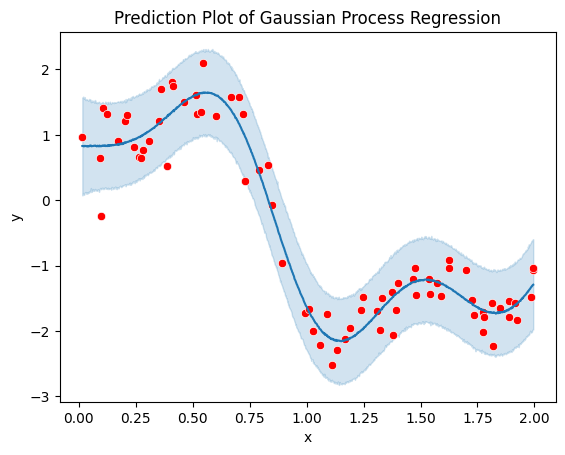

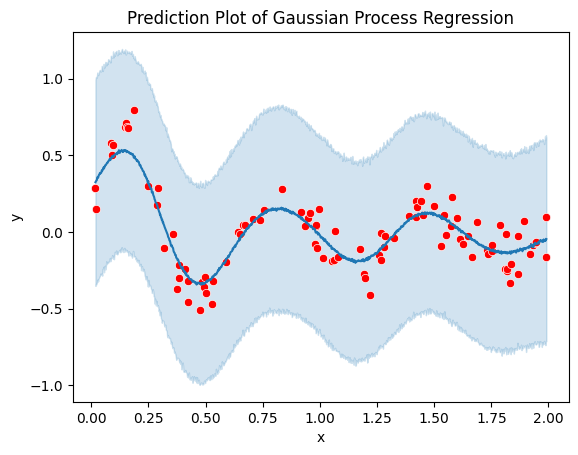

In [ ]:
plot_gp(pred1, d1)
plot_gp(pred2, d2)
plot_gp(pred3, d3)

Generally, the Gaussian Process Regression performs pretty well in these three data sets above. The predictions nicely illustrate the non-linear trend in the data and the 95% CI correctly covers almost all of the true datapoints. 